# 12-Solving Protein Folding Problem by HUBO Solver

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/OpenJij/OpenJijTutorial/blob/master/source/ja/012-ProteinFoldingHubo.ipynb)

2012年に、Alejandroらがタンパク質折り畳み問題を量子アニーリングマシン(D-wave)を用いて解きました[1]。

ここでタンパク質折り畳み問題とは、「アミノ酸配列という１次元的情報からそのタンパク質の３次元的立体構造を予測すること」を意味します。
タンパク質はアミノ酸配列によって特徴付けられ、１つのアミノ酸配列に対して固有の立体構造が対応することが知られています。
タンパク質はその固有の立体構造を持って初めて生体高分子としての機能を果たすため、アミノ酸配列の情報からそのタンパク質の立体構造を予測することは非常に重要な問題です。
しかし、アミノ酸配列とタンパク質の立体構造との因果関係はまだよくわかっておらず、非常に難しい問題です。

このチュートリアルでは、OpenJijのHUBOソルバーを用いてタンパク質折り畳み問題を解き、その結果を論文[1]と比較します。

## 問題の概要とHydrophobic-Polar(HP)モデル、Miyazawa-Jernigan(MJ)モデル 

### 問題概要
タンパク質の立体構造をラティスフォールディングモデルという単純な格子モデルとして捉え、HUBOの形式にエンコードしこれを解くことで立体構造を決定します。
ラティスフォールディングモデルにはいくつか種類があり、 以下代表的な２つのモデル、HPモデルとMJモデルについて紹介します。
論文[1]では、２次元上の構造問題とみなして以下で説明するMJモデルを利用しています。

### HPモデル 
タンパク質は数十から数百程度のアミノ酸配列からなるポリペプチドが折り畳まった安定した立体構造を持ちます。
その立体構造を決定するために、ポリペプチドの３次元立体構造をそのままの状態で扱うのは、計算量が膨大でスーパーコンピュータ等を利用しても難しいのが現状です。
なぜなら、タンパク質分子のエネルギーを計算するには、水素結合、静電相互作用、ファンデルワールス力、疎水性相互作用等の様々な力を考慮する必要があるからです。
しかし、疎水性相互作用だけを扱った極めて単純なモデルでもある程度のことが説明できます。

LauとDillは疎水性相互作用のみを考慮した格子モデルであるHPモデル[2]を提案しました。
このモデルは、アミノ酸を疎水性(H: hydrophobic)と親水性(P: polar)の2種類のみに分類し､タンパク質のアミノ酸配列をHとPの配列として表現します。
そして､Hモノマー同士が最近接格子にきた場合､エネルギーが下がるというモデルです。

参考：
- https://repository.kulib.kyoto-u.ac.jp/dspace/bitstream/2433/96792/1/KJ00004709268.pdf
- http://www.iba.t.u-tokyo.ac.jp/iba/AI/HP.pdf


### MJモデル
HPモデルでは、アミノ酸を単純化して疎水性と親水性の2種類のみに分類しました。つまり、アミノ酸同士の相互作用の大きさの違いは考慮していません。
より精度の高いモデルを構築しようとした場合、この違いを考慮することが考えられます。それがMJモデルです。

MJモデルは、立体構造が既知のタンパク質を多数集め、それらの中から互いに近距離にあるアミノ酸ペアの個数を数え上げ、それらの統計的な情報をアミノ酸間の相互作用エネルギーとして表現したものです。
立体構造群の中でのアミノ酸ペアの数が多ければ、そのアミノ酸ペアに働く相互作用エネルギーの絶対値は大きくなります。
この相互作用エネルギーは、アミノ酸ペアを形成しやすい・しにくいという傾向を表現していると考えられます。

論文[1]では参考論文[3]のTable3に報告されている値を利用しています。

## 解法の概要
ここでは論文[1]で扱っているモデルの構築方法について説明します。
今回使用するアミノ酸配列は、Proline-Serine-Valine-Lysine-Methionine-Alanineの6アミノ酸配列(1文字のアミノ酸配列表記ではP-S-V-K-M-A)です。
ここでP-S-V-K-M-Aというアミノ酸の順番は固定されていることに注意してください。
2次元の格子上でこれらのアミノ酸列の折りたたみ問題を考えます。
ただし、6種類とはいえアミノ酸配列を全て一度に処理するのは難しいので、すでにいくつかの折り畳まれたパターンを起点に考えてモデルを構築します。
以下では簡単な例として論文[1]のscheme3について解説します。

本チュートリアルでは以下の順で詳細な解法手順を説明します。

1. ラティスフォールディングのビット表現方法
2. コスト関数の定式化
3. HUBOの直接解法
4. HUBOによる直接解法と参考論文[1]の結果との比較

### 1. ラティスフォールディングのビット表現方法
ここでは2次元上のアミノ酸の立体構造とビット列を対応付ける方法を説明します。P-S-V-K-M-A列の構造を例に考えますが、より現実的な3次元の立体構造も同様の方針で対応付けることができます。
方法は非常に簡単です。今は2次元格子を考えているためアミノ酸の折りたたみ方としては、上、下、左、右の4種類あります。これらに対して２つのビットを次のように割り当てます。
$$
00(下向き)、01(右向き)、10(左向き)、11(上向き)
$$
これにより、$2\times 6=12$個のビット列と6個のアミノ酸列の2次元格子上の構造が1対1で対応します。
例えば010101010101というビット列は左から2ビットずつ区切って読むことで、右、右、右、右、右、右という列に翻訳されます。
よってP-S-V-K-M-Aという順番でアミノ酸が右向きに横一直線に並んだ構造に対応します。
より複雑な例が図１に示してあります。

実は、簡単な考察から最初の3ビットは010に固定できることが分かります。
まず、平面の対称性からPの右側にSが折りたたまれていると仮定しても一般性を失わないことが分かります。よって最初の2ビットは01列で固定できます。
さらにSの上にVが折りたたまれることと、下に折りたたまれることは、やはり平面の対称性から同じことなので、ここでは下に折りたたまれる場合のみ考えます。
またVがSの左に折りたたまれてPと重なるパターンも排除します。以上の考察と仮定からVはSの右か下に折りたたまれる場合のみを考えても良いことになります。
したがって3ビット目が0に決まります。よって残りの$12-3=9$ビットの配列を決定すれば良いことになります。

<div>
    <img src="images/lattice_folding_mapping.png" width="400" height="300">
    
    図1：ラティスフォールディングとビット列の対応関係。
    最終的に得られている0100101011というビット列を2ビットずつ区切って左から読むと、右、下、左、左、上となるので図のような2次元構造が対応することが分かります。
    論文[1]のFigure2(a)より転載: Alejandro Perdomo-Ortiz, Neil Dickson, Marshall Drew-Brook, Geordie Rose and Alán Aspuru-Guzik, Finding low-energy conformations of lattice protein models by quantum annealing. Sci Rep 2, 571 (2012). https://doi.org/10.1038/srep00571 ([CC-BY 4.0.](https://creativecommons.org/licenses/by/4.0/))
</div>

### 2. コスト関数の定式化

ここでは具体的なコスト関数の定式化方法を説明します。
論文[1]では以下の２つの項の寄与を考えています。

$$
E_\mathrm{p} = E_\mathrm{onsite} + E_\mathrm{pw}
$$

- 第１項: アミノ酸同士が重なった場合のエネルギー
- 第２項: アミノ酸同士が隣り合わせになった場合の相互作用のエネルギー(pw: pair-wise)

第1項については論文[1]に詳細な記述がなかったため、アミノ酸によらず一律に$\lambda$というエネルギーの寄与があるものとみなし、最終的に$\lambda=11$としました。また第2項については論文[1]のFigure 3(a)の表を利用しています。これは以下の図3の左下に転載しています。

具体的な例として論文[1]のScheme3のExperiment3を初期状態にして考えます。アミノ酸配列は、

P-S-V-K-M-A

でしたが、P-S-V-Kの構造は以下の図2の様にすでに決まっています。
残りのMとAの構造を決定するコスト関数を考えます。
<div>
    <img src="images/scheme.png" width="600" height="600"><br />
    
     図2：赤枠内の構造を初期状態として考えます。MはKの下または左に折りたたまれる場合のみを考えます。よって決定変数は$q_1$、$q_2$、$q_3$の3つとなります。
     論文[1]のFigure 3(b)を改変して作成: Alejandro Perdomo-Ortiz, Neil Dickson, Marshall Drew-Brook, Geordie Rose and Alán Aspuru-Guzik, Finding low-energy conformations of lattice protein models by quantum annealing. Sci Rep 2, 571 (2012). https://doi.org/10.1038/srep00571 ([CC-BY 4.0.](https://creativecommons.org/licenses/by/4.0/))
</div>

### コスト関数設計

コスト関数設計の様子を以下の図3に示しました。図3の詳細について説明します。

<div>
    <img src="images/make_costfunction_about_protein_folding.png" width="600" height="400"><br />

    図3：コスト関数の定式化。
    論文[1]のFigure 3(a)を改変して作成: Alejandro Perdomo-Ortiz, Neil Dickson, Marshall Drew-Brook, Geordie Rose and Alán Aspuru-Guzik, Finding low-energy conformations of lattice protein models by quantum annealing. Sci Rep 2, 571 (2012). https://doi.org/10.1038/srep00571 ([CC-BY 4.0.](https://creativecommons.org/licenses/by/4.0/))
</div>

</br>
基本的な方針は簡単で、ありうる２次元構造を全て考えて対応するエネルギーを計算することでコスト関数を導出します。
ただしこの方法ではコスト関数の導出そのものに指数時間かかることになります。また、取りうるエネルギーを毎回計算しているため、わざわざアニーリングで解を求めなくてもコスト関数ができた段階で最適解が分かっていることになります。
ここでは論文[1]の式(5)の導出をわかりやすく説明するためのこのような説明を行っています。

それでは具体的に見ていきます。すぐに分かることとして、

1. 初期状態でP-Kの相互作用で-1のエネルギーが生じている

ことがあげられます。これはビット列に依存しないコスト関数の定数項ですが論文[1]の式(5)には確かに-1という定数項が現れています。

コスト関数として意味のある項は、全ての取りうるエネルギーを数え上げることで求めます。つまり、
未知のビット列$(q_{1},q_{2},q_{3})$の取りうる$2^{3}=8$個のパターン全てに対応する2次元構造を考えてみます。
この中で有限のエネルギー寄与がある組み合わせは以下の2〜5で示したビット列のみであることが分かります。

ここで、最近接のアミノ酸間の相互作用によるエネルギーは図3の左下の表を用いています。
また、アミノ酸同士が重なったことによるエネルギーは図3では$\lambda$と表現されていますが、$\lambda=11$とすることで論文[1]の式(5)と一致します。

2. $(q_{1},q_{2},q_{3})=(0,0,1)$。V-Aの相互作用で-4のエネルギーが生じます。
この場合のコスト関数は以下のようになります。

 $$(1-q_{1})(1-q_{2})q_{3}(-4)$$

3. $(q_{1},q_{2},q_{3})=(0,1,1)$。P-A,V-Aの相互作用で-2,-4のエネルギーが生じます。
またM-Aの押り返しによるコスト$\lambda=11$が生じます。合計で+5のエネルギーが生じます。
この場合のコスト関数は以下のようになります。

　$$(1-q_{1})q_{2}q_{3}(+5)$$

4. $(q_{1},q_{2},q_{3})=(1,1,1)$。P-Aの相互作用で-2のエネルギーが生じます。
この場合のコスト関数は以下のようになります。

　$$q_{1}q_{2}q_{3}(-2)$$

5. $(q_{1},q_{2},q_{3})=(1,0,1)$。P-A,V-Aの相互作用で-2,-4のエネルギーが生じます。
またM-Aの押り返しによるコスト$\lambda=11$が生じます。合計で+5のエネルギーが生じます。
この場合のコスト関数は以下のようになります。

　$$q_{1}(1-q_{2})q_{3}(+5)$$


1〜5の式を合計すると、コスト関数として最終的に以下の式が得られます。

$$E = -1-4q_3+9q_1q_3+9q_2q_3-16q_1q_2q_3$$

また、明らかにこのコスト関数の最小値は-5でその時のビット列は$(q_{1},q_{2},q_{3})=(0,0,1)$であることが分かります。

### 3. HUBOソルバーによる解法

上で求めたコスト関数をOpenJijのHUBOソルバーを使って解きます。論文[1]ではD-waveを用いて１万回の測定を行っているため、HUBOソルバーでも1万回シミュレーションを行います。

In [1]:
# コスト関数を定義します。
polynomial = {():-1, (3,): -4, (1,3): 9, (2,3): 9, (1,2,3): -16}

In [2]:
import openjij as oj

# HUBOメソッドを利用するためには、SASamplerメソッドを用いる必要があります。
sampler = oj.SASampler()

# SAによるシミュレーションを行う回数を指定します。ここでは、論文[1]でD-waveを用いて１万回の測定を行ったため、１万回に指定します。
num_reads = 10000 

# 変数は、バイナリ変数、変数の更新方式は、single spin flipを指定します。
response = sampler.sample_hubo(polynomial, "BINARY", updater="single spin flip", num_reads=num_reads)

 sample_huboメソッドを用いて10000回実行したところ、異なる種類の解が複数回得られることがわかります。
 解の頻度について、エネルギーのヒストグラムとして可視化してみましょう。

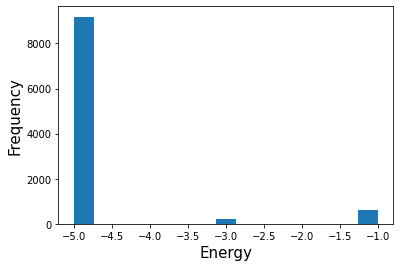

In [3]:
import matplotlib.pyplot as plt

plt.hist(response.energies, bins=15)
plt.xlabel('Energy', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

エネルギーが-5となる解が最も多く得られていることがわかります。これは先程述べたように厳密な最適解となっています。

またこの時のビット列は$(q_{1},q_{2},q_{3})=(0,0,1)$であり、対応する2次元構造は以下のようになります。

<div>
    <img src="images/optimal_folding_structure.png" width="300" height="300"><br />
    
    図4： 最適なラティスフォールディング構造。
    論文[1]のFigure 3(c)を改変して作成: Alejandro Perdomo-Ortiz, Neil Dickson, Marshall Drew-Brook, Geordie Rose and Alán Aspuru-Guzik, Finding low-energy conformations of lattice protein models by quantum annealing. Sci Rep 2, 571 (2012). https://doi.org/10.1038/srep00571 ([CC-BY 4.0.](https://creativecommons.org/licenses/by/4.0/))
</div>

### 4. HUBOによる直接解法と参考論文[1]の結果との比較

最後に、HUBOによる直接解法と参考論文[1]の結果との比較します。
以下の図5は、論文[1]による測定結果であり、各エネルギーにおいてタンパク質がとり得る2次元構造を示したものです。
なお、論文[1]では、HUBOをQUBOに変換してから、D-waveを用いて解いています。

<div>
    <img src="images/protein_folding_qa_result.png" width="800" height="1000"><br />
    
    図5： 測定結果で得られたラティスフォールディング構造とエネルギーのパターン。
    論文[1]のFigure 3(c)より転載: Alejandro Perdomo-Ortiz, Neil Dickson, Marshall Drew-Brook, Geordie Rose and Alán Aspuru-Guzik, Finding low-energy conformations of lattice protein models by quantum annealing. Sci Rep 2, 571 (2012). https://doi.org/10.1038/srep00571 ([CC-BY 4.0.](https://creativecommons.org/licenses/by/4.0/))
</div>

</br>
今回注目したScheme3のExperiment3の測定結果は、図の青色の構造であり、今回は青色の構造のみを観察すれば良いです。

図5に従い、参考論文[1]のエネルギー測定結果のリストを以下で作成します。注意点として、エネルギーが正の値になる構造は無視しています。論文[1]によるとそのような構造は全体の8%を締めていたようです。

In [4]:
import numpy as np

energy_qa = np.zeros(num_reads)
# エネルギー -5の解は、4164回得られました。
energy_qa[:4164] = -5 
# エネルギー -3の解は、1317回得られました。
energy_qa[4164:4164+1317] = -3
# エネルギー -1の解は、４状態の構造について、それぞれ415回, 381回, 1371回, 1552回の計3719回得られました。
energy_qa[4164+1317:4164+1317+415+381+1371+1552] = -1


両者を比較した結果をヒストグラムにすると以下のようになります。

Text(0, 0.5, 'Frequency')

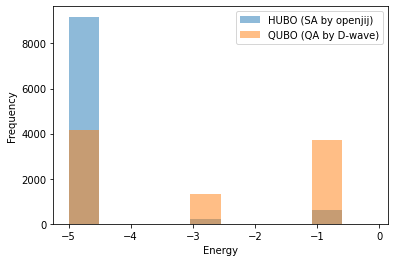

In [5]:
plt.hist(response.energies, label='HUBO (SA by openjij)', range=(-5, -0.1), bins=10, alpha=0.5)
plt.hist(energy_qa, label='QUBO (QA by D-wave)', range=(-5, -0.1), bins=10, alpha=0.5)
plt.legend()
plt.xlabel('Energy')
plt.ylabel('Frequency')

SAとQAなので単純比較はできませんが、今回の結果からは、HUBO直接解法(openjijを用いたSA)の方が、QUBO変換解法(D-waveを用いたQA)に比べ、
最適解を導くエネルギーを多く得ることができていることがわかります。

## 引用文献

1. Alejandro Perdomo-Ortiz, et.al "Finding low-energy conformations of lattice protein models by quantum annealing". Scientific Reports volume 2, Article number: 571 (2012)
2. Dill KA (March 1985). "Theory for the folding and stability of globular proteins". Biochemistry. 24 (6)
3. Miyazawa, S. & Jernigan, R. L. Residue-residue potentials with a favorable contact pair term and an unfavorable high packing density term, for simulation and threading. J. Mol. Biol. 256, 623–644 (1996).